In [20]:
import numpy as np
from matplotlib import pyplot as plt

# Supernova data
from astroML.datasets import generate_mu_z

# Machine learning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve

# Still machine learning. It is sklearn based
from astroML.linear_model import LinearRegression
from astroML.linear_model import PolynomialRegression
from astroML.linear_model import BasisFunctionRegression
from astroML.linear_model import NadarayaWatson

In [21]:
# Random generate some supernova data
z_sample, mu_sample, dmu = generate_mu_z(size=100, random_state=20240509)

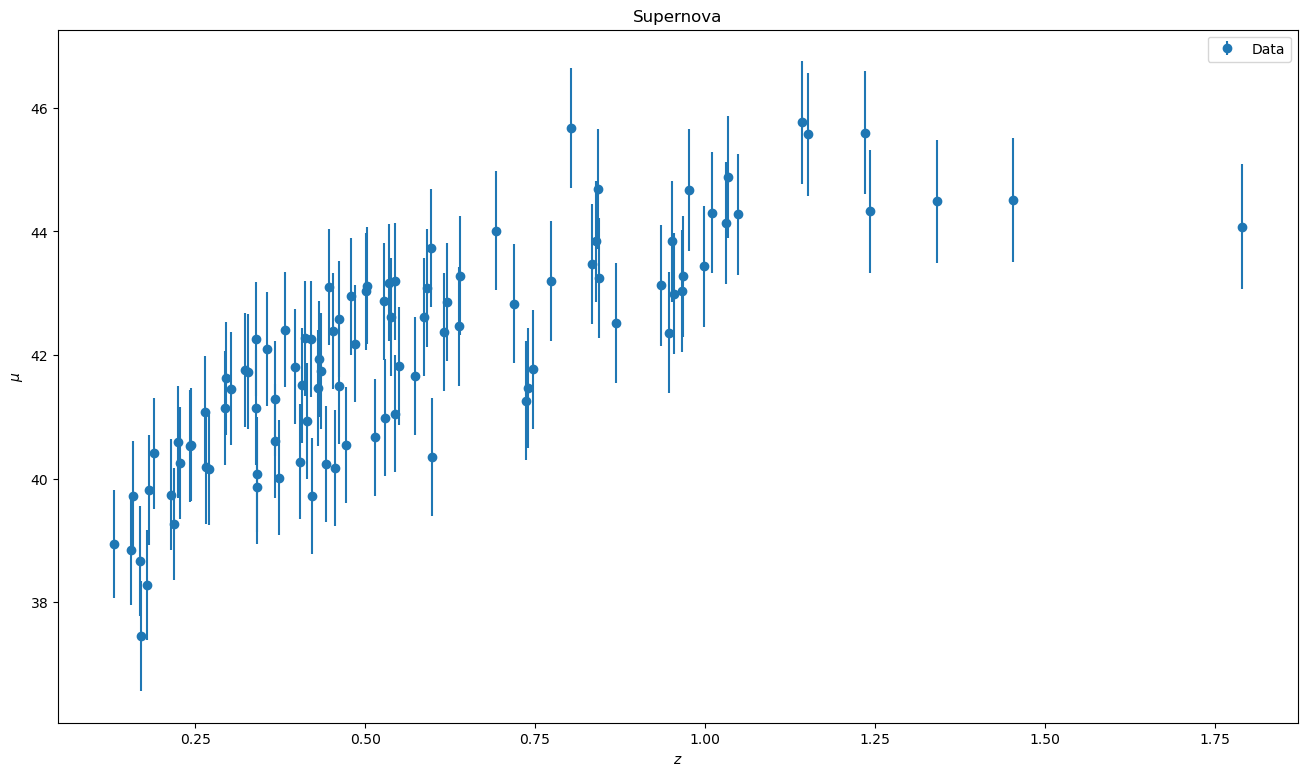

In [22]:
# Plot the data
fig, ax = plt.subplots(figsize=(16, 9))

ax.set_title('Supernova')
ax.set_xlabel(r'$z$')
ax.set_ylabel(r'$\mu$')

ax.errorbar(z_sample, mu_sample, yerr=dmu, linestyle='', marker='o', label='Data')

ax.legend()

plt.show()

# Linear Regression

In [23]:
# Fit a linear model to the data
lr = LinearRegression()
lr.fit(z_sample[:, np.newaxis], mu_sample, dmu)

LinearRegression()

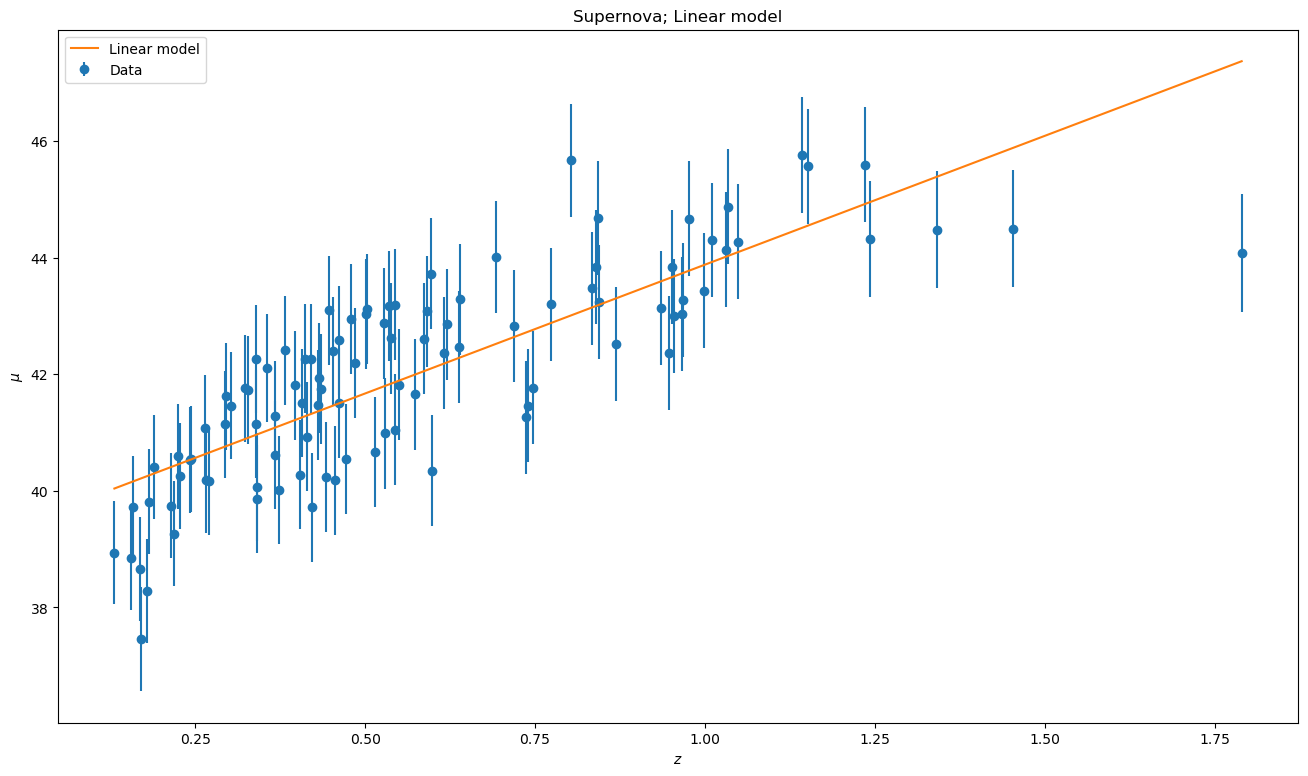

In [24]:
# Overplot the linear model to the data
fig, ax = plt.subplots(figsize=(16, 9))

ax.set_title('Supernova; Linear model')
ax.set_xlabel(r'$z$')
ax.set_ylabel(r'$\mu$')

# Define a z grid for the model
n_grid_points = 1000
z_grid = np.linspace(np.min(z_sample), np.max(z_sample), n_grid_points)

# Data
ax.errorbar(z_sample, mu_sample, yerr=dmu, linestyle='', marker='o', label='Data', zorder=0)

# Linear model
ax.plot(z_grid, lr.predict(z_grid[:, np.newaxis]), label='Linear model', zorder=1)

ax.legend()

plt.show()

# Polynomial Regression

In [25]:
# Choose the maximum degree to fit and create a list of degrees
max_deg = 8
deg_list = list(range(2, max_deg + 1))

In [26]:
# Make polynomial models with different degrees and fit them
poly_models = [PolynomialRegression(degree=deg) for deg in deg_list]

for i in range(len(deg_list)):
    poly_models[i].fit(z_sample[:, np.newaxis], mu_sample, dmu)

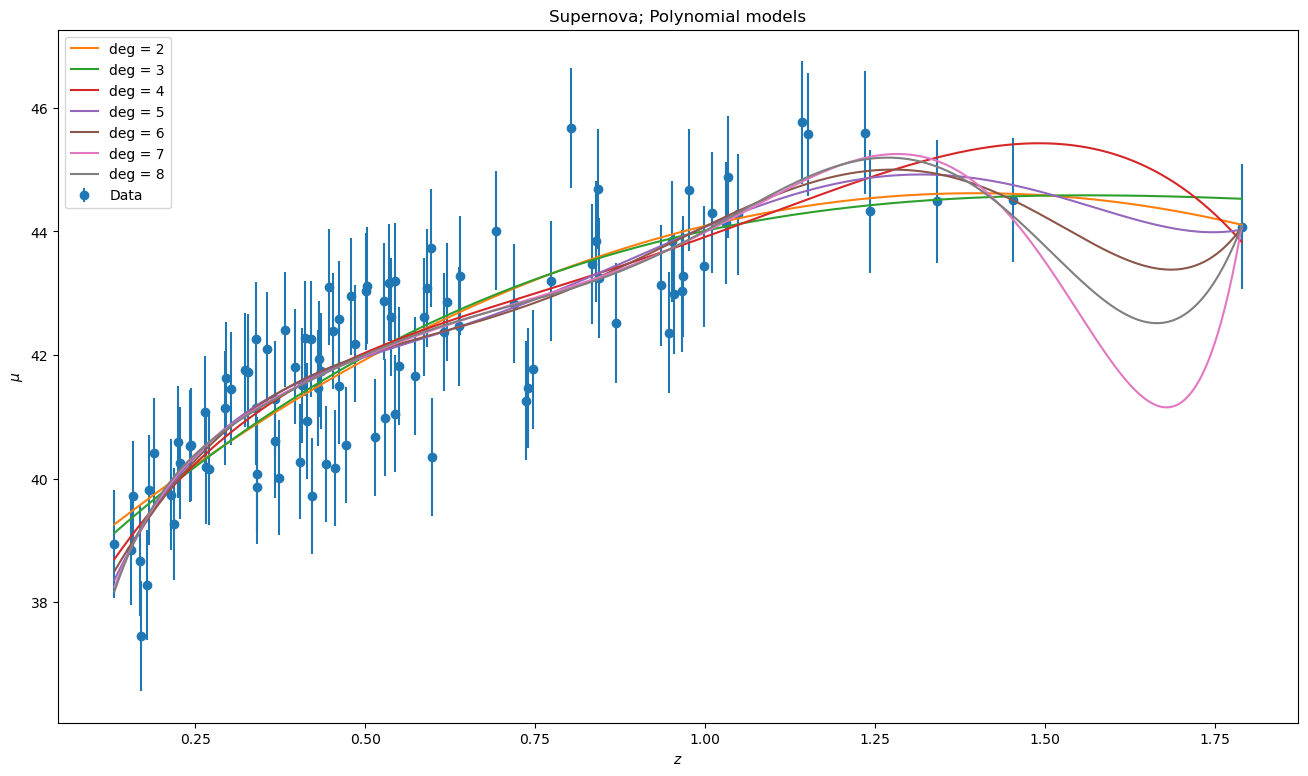

In [27]:
# Overplot the polynomial models to the data
fig, ax = plt.subplots(figsize=(16, 9))

ax.set_title('Supernova; Polynomial models')
ax.set_xlabel(r'$z$')
ax.set_ylabel(r'$\mu$')

# Data
ax.errorbar(z_sample, mu_sample, yerr=dmu, linestyle='', marker='o', label='Data', zorder=0)

# Polynomials
for i in range(len(deg_list)):
    ax.plot(z_grid, poly_models[i].predict(z_grid[:, np.newaxis]), label='deg = ' + str(deg_list[i]), zorder=1)

ax.legend()

plt.show()

In [28]:
# Perform Cross Validation on the model to find the best degree
# See the scoring documentation
deg_grid = GridSearchCV(PolynomialRegression(), dict(degree=deg_list),
                        cv=5, scoring='neg_mean_squared_error')
deg_grid.fit(z_sample[:, np.newaxis], mu_sample, y_error=dmu)

GridSearchCV(cv=5, estimator=PolynomialRegression(),
             param_grid={'degree': [2, 3, 4, 5, 6, 7, 8]},
             scoring='neg_mean_squared_error')

In [29]:
print("The best degree for our polynomial is:", deg_grid.best_params_['degree'])

The best degree for our polynomial is: 2


# Kernel Regression

In [30]:
# Choose some bandwiths (h) for the kernels and fit them
bw = [0.01, 0.05, 0.1, 0.5]
kernel_models = [NadarayaWatson(kernel='gaussian', h=h) for h in bw]

for i in range(len(bw)):
    kernel_models[i].fit(z_sample[:, np.newaxis], mu_sample)

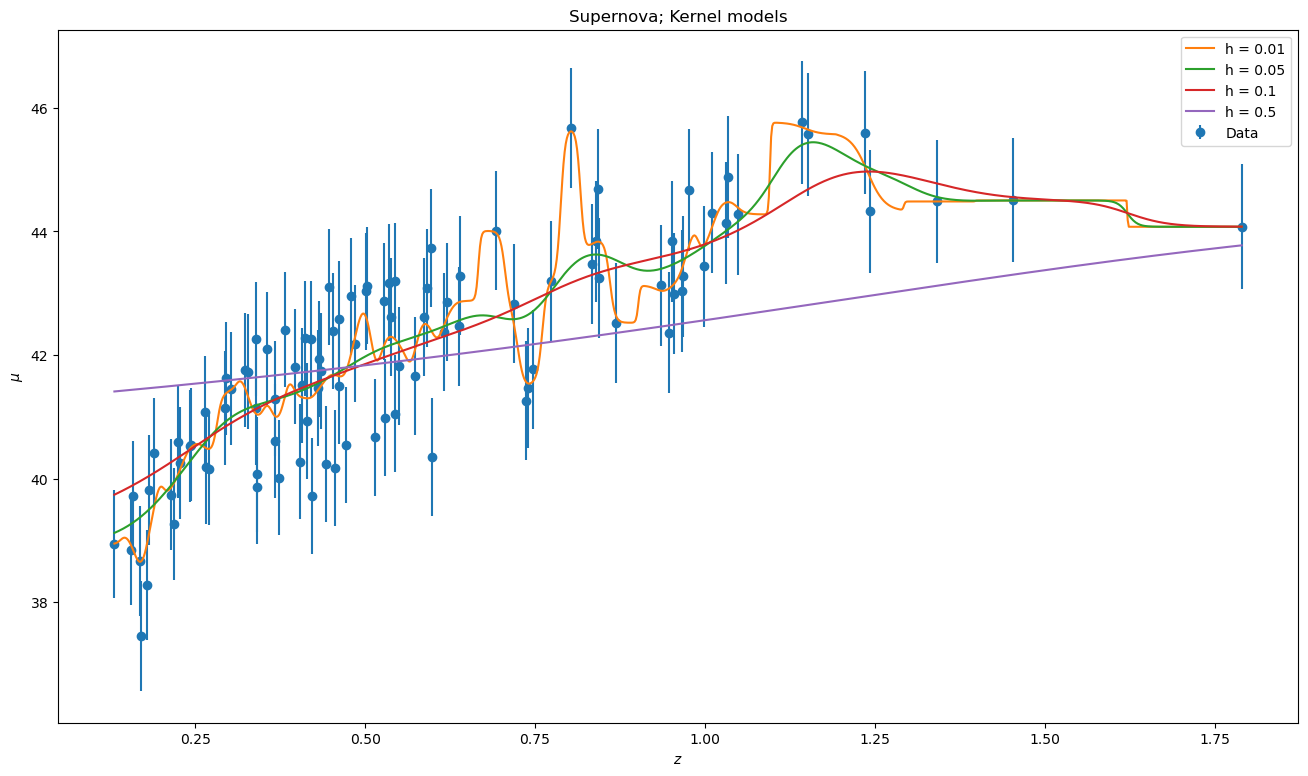

In [31]:
# Overplot the kernel models to the data
fig, ax = plt.subplots(figsize=(16, 9))

ax.set_title('Supernova; Kernel models')
ax.set_xlabel(r'$z$')
ax.set_ylabel(r'$\mu$')

# Data
ax.errorbar(z_sample, mu_sample, yerr=dmu, linestyle='', marker='o', label='Data', zorder=0)

# Kernel models
for i in range(len(bw)):
    ax.plot(z_grid, kernel_models[i].predict(z_grid[:, np.newaxis]), label='h = ' + str(bw[i]), zorder=1)

ax.legend()

plt.show()

In [32]:
# Perform Cross Validation on the model to find the best h
# See the scoring documentation
bw_grid = np.linspace(0.01, 0.5, 100)
h_grid = GridSearchCV(NadarayaWatson(), dict(h=bw_grid),
                      cv=5, scoring='neg_mean_squared_error')

h_grid.fit(z_sample[:, np.newaxis], mu_sample)

GridSearchCV(cv=5, estimator=NadarayaWatson(),
             param_grid={'h': array([0.01      , 0.01494949, 0.01989899, 0.02484848, 0.02979798,
       0.03474747, 0.03969697, 0.04464646, 0.04959596, 0.05454545,
       0.05949495, 0.06444444, 0.06939394, 0.07434343, 0.07929293,
       0.08424242, 0.08919192, 0.09414141, 0.09909091, 0.1040404 ,
       0.1089899 , 0.11393939, 0.11888889, 0.12383838, 0.12878788,
       0.13373737, 0.13...
       0.35646465, 0.36141414, 0.36636364, 0.37131313, 0.37626263,
       0.38121212, 0.38616162, 0.39111111, 0.39606061, 0.4010101 ,
       0.4059596 , 0.41090909, 0.41585859, 0.42080808, 0.42575758,
       0.43070707, 0.43565657, 0.44060606, 0.44555556, 0.45050505,
       0.45545455, 0.46040404, 0.46535354, 0.47030303, 0.47525253,
       0.48020202, 0.48515152, 0.49010101, 0.49505051, 0.5       ])},
             scoring='neg_mean_squared_error')

In [33]:
print("The best h for our kernel is:", h_grid.best_params_['h'])

The best h for our kernel is: 0.04464646464646465


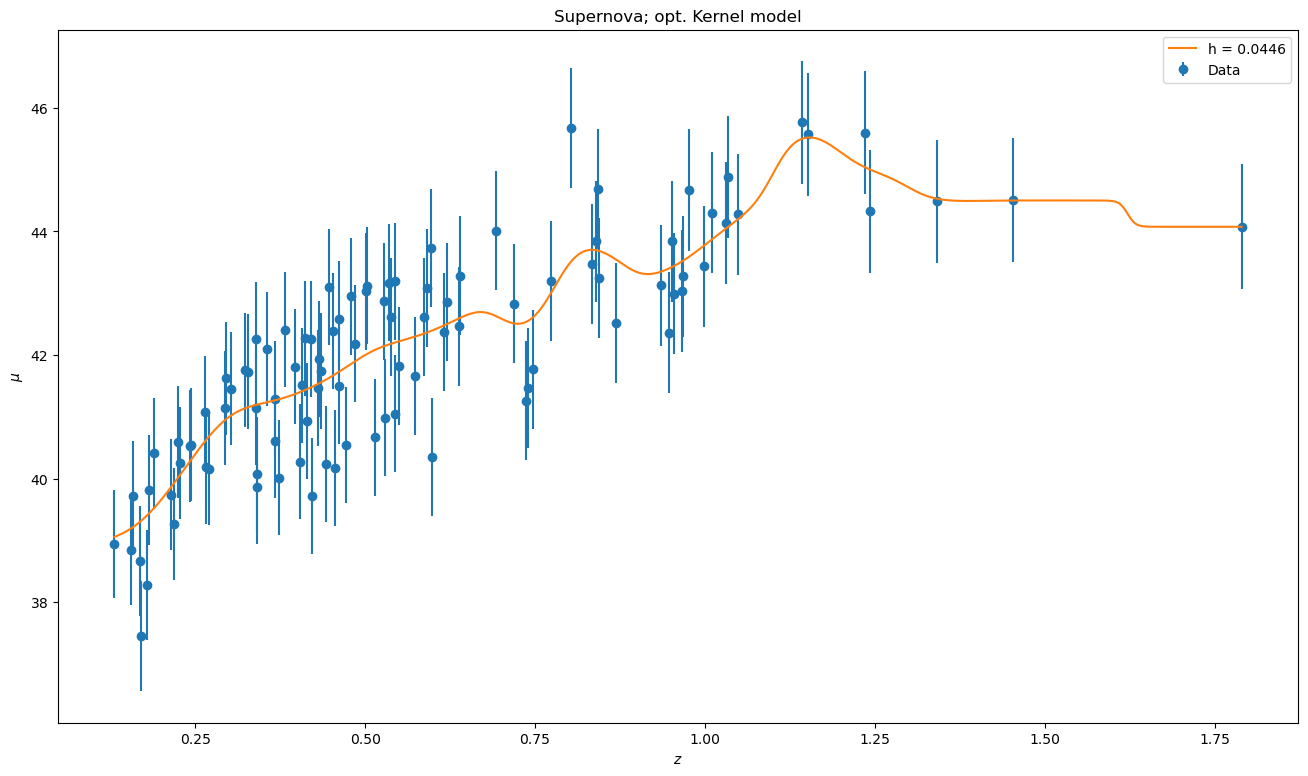

In [34]:
# Make a kernel with the best bandwith h and plot it
kernel_model = NadarayaWatson(kernel='gaussian', h=h_grid.best_params_['h'])
kernel_model.fit(z_sample[:, np.newaxis], mu_sample)

# Overplot the optimized kernel model to the data
fig, ax = plt.subplots(figsize=(16, 9))

ax.set_title('Supernova; opt. Kernel model')
ax.set_xlabel(r'$z$')
ax.set_ylabel(r'$\mu$')

# Data
ax.errorbar(z_sample, mu_sample, yerr=dmu, linestyle='', marker='o', label='Data', zorder=0)

# Kernel model
ax.plot(z_grid, kernel_model.predict(z_grid[:, np.newaxis]),
        label='h = ' + np.format_float_positional(h_grid.best_params_['h'], 4), zorder=1)

ax.legend()

plt.show()

In [35]:
# Make the learning curve of the model
train_size_abs, train_scores, test_scores = learning_curve(kernel_model,
                                                           z_sample[:, np.newaxis], mu_sample,
                                                           scoring='neg_mean_squared_error',
                                                           train_sizes=np.linspace(0.1, 1, 10),
                                                           cv=5)

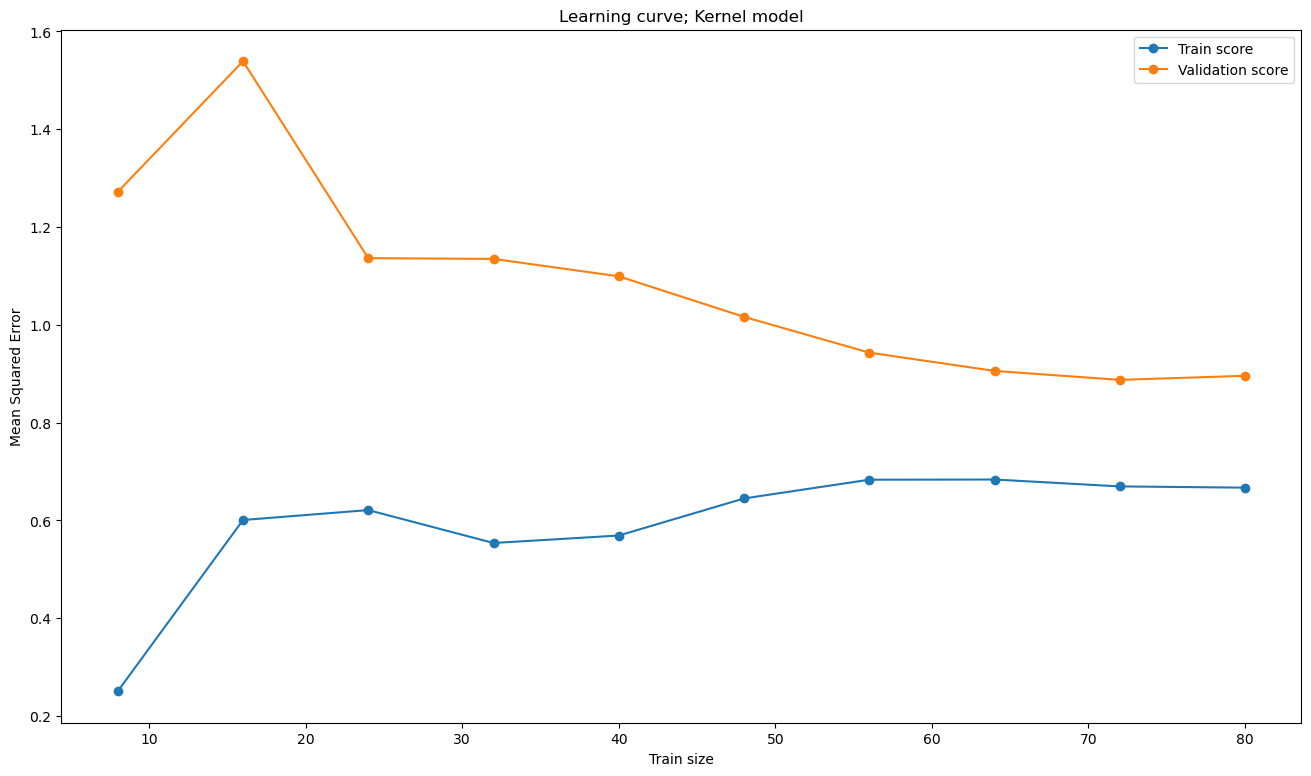

In [36]:
# Plot the learning curves
fig, ax = plt.subplots(figsize=(16, 9))

ax.set_title("Learning curve; Kernel model")
ax.set_xlabel("Train size")
ax.set_ylabel("Mean Squared Error")

ax.plot(train_size_abs, -np.mean(train_scores, axis=1), marker='o', label='Train score')
ax.plot(train_size_abs, -np.mean(test_scores, axis=1), marker='o', label='Validation score')

ax.legend()

plt.show()

Probably adding more data wouldn't improove the model.

# Basis Function Regression

In [37]:
# Make a gaussian bases model (see documentation)
gaus_base_model = BasisFunctionRegression(basis_func='gaussian',
                                          mu=np.linspace(np.min(z_sample), np.max(z_sample), 10)[:, np.newaxis],
                                          sigma=3)
gaus_base_model.fit(z_sample[:, np.newaxis], mu_sample, dmu)

BasisFunctionRegression()

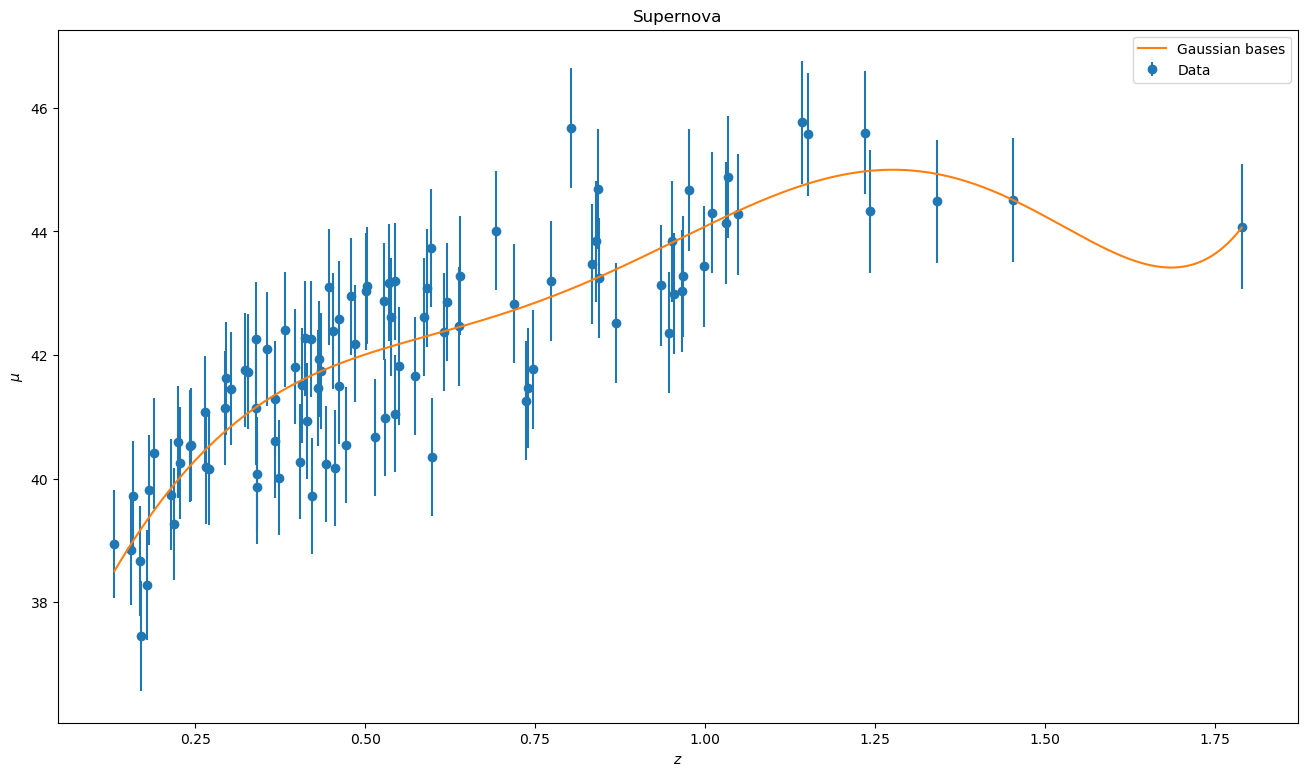

In [38]:
# Overplot the gaussian bases model to the data
fig, ax = plt.subplots(figsize=(16, 9))

ax.set_title('Supernova')
ax.set_xlabel(r'$z$')
ax.set_ylabel(r'$\mu$')

# Data
ax.errorbar(z_sample, mu_sample, yerr=dmu, linestyle='', marker='o', label='Data', zorder=0)

# Gaussian bases model
ax.plot(z_grid, gaus_base_model.predict(z_grid[:, np.newaxis]), label='Gaussian bases', zorder=1)

ax.legend()

plt.show()

Apparently the _BasisFunctionRegression_ implementation from **_AstroML_** doens't seem to be compatible with the Scikit-learn _GridSearchCV_ interface. I won't implement a Cross Validation tecnique my self for this problem because I'm lazy.